In [ ]:
require(lme4)
require(lmerTest)
require(MASS)
require(ggplot2)
require(dplyr)

In [3]:
data = read.csv("data/all_data.csv")

cat("removing a nasality outlier of ")
cat((max(data$nasality)-median(data$nasality))/IQR(data$nasality)); cat(" IQR\n")
data = data[data$nasality < 40, ]
cat("removing a data point with no function annotation\n")
data = data[data$function_1!="",]

data$file = factor(data$file)
data$speaker_gender = factor(data$speaker_gender)
data$position = relevel(factor(data$position), ref='f')
data$syllable_structure = relevel(factor(data$syllable_structure), ref='cv')
data$function_1 = relevel(factor(data$function_1), ref='b')
data$function_2 = relevel(factor(data$function_2), ref='b')
names(data)[names(data)=="nasality..a1.p0."] = "nasality"

removing a nasality outlier of 5.853688 IQR
removing a data point with no function annotation


In [4]:
names(data)

[1] "file"                "time_start"          "time_end"           
 [4] "time_midpoint"       "speaker_gender"      "context_raw"        
 [7] "position"            "syllable_structure"  "nasalized_perceived"
[10] "function_1"          "function_2"          "nasality"           
[13] "freq_f1"             "freq_f2"             "freq_f3"

In [5]:
head(data)

,file,time_start,time_end,time_midpoint,speaker_gender,context_raw,position,syllable_structure,nasalized_perceived,function_1,function_2,nasality,freq_f1,freq_f2,freq_f3
,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<int>
1,127849,12.42569,13.07296,12.99933,m,h_oN_f,f,cv,1,b,b,2.62,581,1116,2568
2,127849,20.60964,21.27795,21.19380,m,h_oN_f,f,cv,1,a,a,8.88,581,1080,2692
3,127849,21.16914,21.79538,21.73226,m,h_oN_f,f,cv,1,b,b,6.92,581,1124,2551
4,127849,22.98549,23.59069,23.53809,m,h_oN_f,f,cv,1,a,a,3.70,560,1119,2746
5,127849,26.13353,26.80885,26.72119,m,h_oN_f,f,cv,1,a,a,6.37,581,1088,2928
6,127849,27.33452,27.93972,27.88712,m,h_oN_f,f,cv,1,b,b,5.34,581,1105,2749


In [6]:
sum(data$function_1 == data$function_2)/nrow(data)

[1] 0.8759398

In [7]:
f1_bc = boxcox(lm(data$freq_f1~1), plotit=F)
print(f1_bc$x[which.max(f1_bc$y)])
data$freq_f1_cox = data$freq_f1 ^ 1.2

[1] 1.2


In [8]:
f2_bc = boxcox(lm(data$freq_f2~1), plotit=F)
print(f2_bc$x[which.max(f2_bc$y)])
data$freq_f2_cox = data$freq_f2 ^ -1.6 

[1] -1.7


In [9]:
f3_bc = boxcox(lm(data$freq_f3~1), plotit=F)
print(f3_bc$x[which.max(f3_bc$y)])
data$freq_f3_cox = data$freq_f3 ^ -2

[1] -2


In [10]:
nas_tr = data$nasality - min(data$nasality)+0.01
nas_bc = boxcox(lm(nas_tr~1), plotit=F)
print(nas_bc$x[which.max(nas_bc$y)])
data$nasality_cox = nas_tr ^ 1.7

[1] 1.7


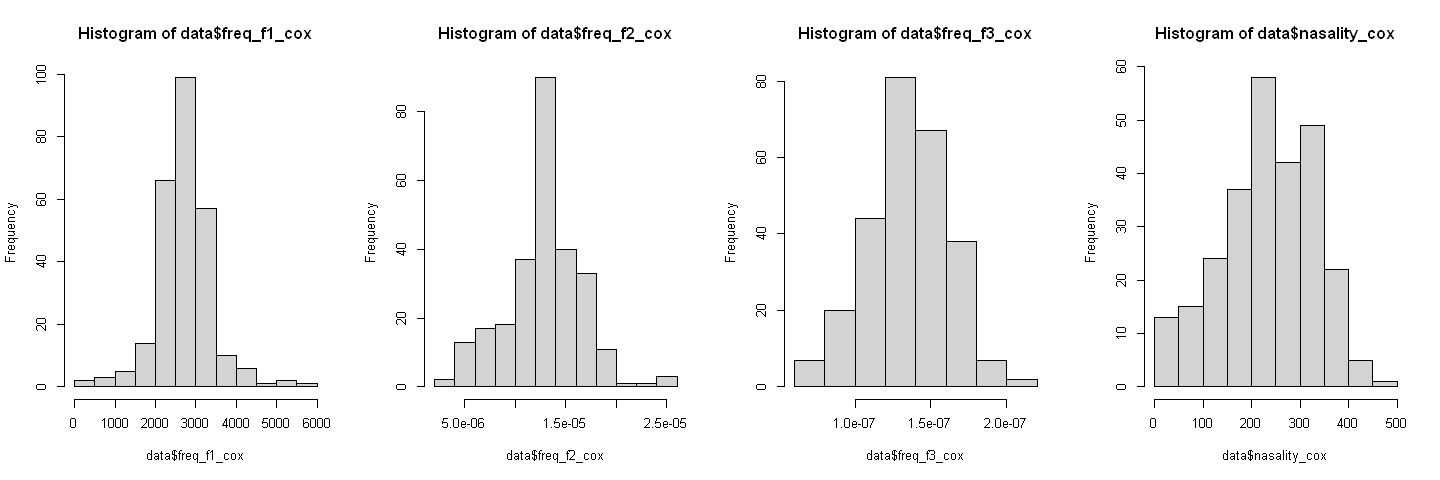

In [10]:
options(repr.plot.width=12, repr.plot.height=4)
par(mfrow=c(1,4))
hist(data$freq_f1_cox)
hist(data$freq_f2_cox)
hist(data$freq_f3_cox)
hist(data$nasality_cox)

In [11]:
addmargins(xtabs(~function_1+file, data=data))

,127849,127889,127903,127909,127940,128068,Sum
b,15,66,64,12,41,14,212
a,6,6,7,0,2,1,22
c,2,7,5,5,10,3,32
Sum,23,79,76,17,53,18,266


In [12]:
addmargins(xtabs(~function_1+position, data=data))

,f,i,Sum
b,146,66,212
a,19,3,22
c,31,1,32
Sum,196,70,266


In [13]:
addmargins(xtabs(~function_1+syllable_structure, data=data))

,cv,v,Sum
b,182,30,212
a,21,1,22
c,23,9,32
Sum,226,40,266


## Nasality index vs. perceived

In [23]:
nas_data = data %>% group_by(nasalized_perceived) %>%
           summarize(mean=mean(nasality), se=sd(nasality)/sqrt(n())) %>%
           ungroup()

In [24]:
nas_data

nasalized_perceived,mean,se
<int>,<dbl>,<dbl>
0,9.251961,0.8501008
1,4.661907,0.4596335


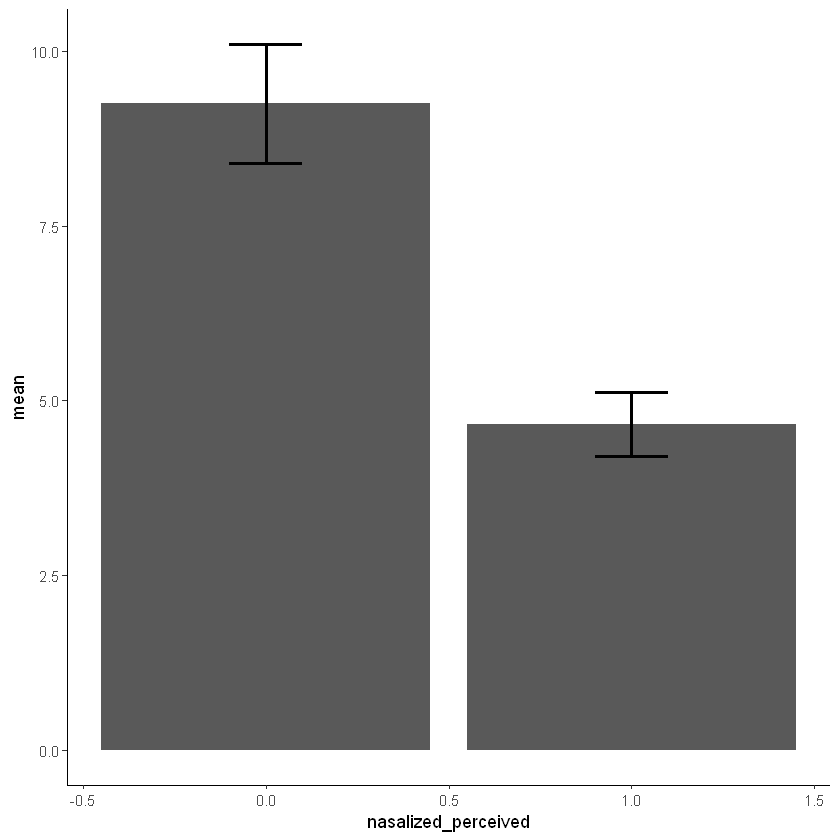

In [32]:
ggplot(nas_data, aes(x=nasalized_perceived, y=mean)) + 
       geom_bar(stat="identity") +
       geom_errorbar(aes(ymin=mean-se, ymax=mean+se), 
                     width=.2, size=1) + 
       theme_classic()

In [14]:
summary(lm(nasality_cox~nasalized_perceived, data=data))


Call:
lm(formula = nasality_cox ~ nasalized_perceived, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-256.789  -63.547    8.803   65.607  211.160 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           293.83      13.11  22.417  < 2e-16 ***
nasalized_perceived   -72.67      14.58  -4.984 1.13e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 93.6 on 264 degrees of freedom
Multiple R-squared:  0.08601,	Adjusted R-squared:  0.08255 
F-statistic: 24.84 on 1 and 264 DF,  p-value: 1.126e-06


In [15]:
summary(glm(nasalized_perceived~nasality, data=data, family="binomial"))


Call:
glm(formula = nasalized_perceived ~ nasality, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7810   0.2552   0.5274   0.7122   1.1346  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.43767    0.32805   7.431 1.08e-13 ***
nasality    -0.13791    0.03322  -4.151 3.31e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 260.00  on 265  degrees of freedom
Residual deviance: 237.22  on 264  degrees of freedom
AIC: 241.22

Number of Fisher Scoring iterations: 5


## Mixed Models

In [16]:
m_f1 = lmer(freq_f1_cox~position+syllable_structure+function_1+(1|file), data=data)
summary(m_f1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: freq_f1_cox ~ position + syllable_structure + function_1 + (1 |  
    file)
   Data: data

REML criterion at convergence: 4132.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7442 -0.5722  0.0374  0.5587  4.4100 

Random effects:
 Groups   Name        Variance Std.Dev.
 file     (Intercept)  46839   216.4   
 Residual             396498   629.7   
Number of obs: 266, groups:  file, 6

Fixed effects:
                    Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)         2654.381    107.582    6.032  24.673 2.74e-07 ***
positioni           -212.178     92.171  260.719  -2.302   0.0221 *  
syllable_structurev  499.520    122.075  226.549   4.092 5.95e-05 ***
function_1a          115.750    144.833  260.115   0.799   0.4249    
function_1c         -127.592    124.039  258.148  -1.029   0.3046    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' '

In [17]:
m_f2 = lmer(freq_f2_cox~position+syllable_structure+function_1+(1|file), data=data)
summary(m_f2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: freq_f2_cox ~ position + syllable_structure + function_1 + (1 |  
    file)
   Data: data

REML criterion at convergence: -5806.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9965 -0.4941  0.1079  0.5040  3.0261 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 file     (Intercept) 1.628e-12 1.276e-06
 Residual             1.145e-11 3.384e-06
Number of obs: 266, groups:  file, 6

Fixed effects:
                      Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)          1.328e-05  6.175e-07  5.442e+00  21.511 1.79e-06 ***
positioni           -3.071e-07  4.958e-07  1.913e+01  -0.619   0.5430    
syllable_structurev -1.774e-06  6.592e-07  1.891e+01  -2.692   0.0145 *  
function_1a         -6.385e-07  7.789e-07  1.913e+01  -0.820   0.4224    
function_1c          6.344e-07  6.668e-07  1.914e+01   0.951   0.3533    
---
Signif. codes:  0 '***' 0.001

In [18]:
m_f3 = lmer(freq_f3_cox~position+syllable_structure+function_1+(1|file), data=data)
summary(m_f3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: freq_f3_cox ~ position + syllable_structure + function_1 + (1 |  
    file)
   Data: data

REML criterion at convergence: -8344.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5267 -0.6472  0.0106  0.6867  2.7977 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 file     (Intercept) 4.819e-18 2.195e-09
 Residual             7.045e-16 2.654e-08
Number of obs: 266, groups:  file, 6

Fixed effects:
                      Estimate Std. Error         df t value Pr(>|t|)
(Intercept)          1.365e-07  2.516e-09  8.736e-03  54.269    0.940
positioni           -1.844e-09  3.818e-09  8.744e-03  -0.483    0.980
syllable_structurev -6.367e-09  4.726e-09  8.744e-03  -1.347    0.971
function_1a         -4.982e-09  6.023e-09  8.744e-03  -0.827    0.975
function_1c          5.549e-09  5.191e-09  8.744e-03   1.069    0.973

Correlation of Fixed Effects:
            (Intr) positn 

In [19]:
m_nas = lmer(nasality_cox~position+syllable_structure+function_1+(1|file), data=data)
summary(m_nas)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: nasality_cox ~ position + syllable_structure + function_1 + (1 |  
    file)
   Data: data

REML criterion at convergence: 3093.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.07417 -0.49052  0.09329  0.69308  2.36644 

Random effects:
 Groups   Name        Variance Std.Dev.
 file     (Intercept) 3295     57.40   
 Residual             7250     85.15   
Number of obs: 266, groups:  file, 6

Fixed effects:
                    Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)         219.3550    24.9376   5.4033   8.796 0.000211 ***
positioni             8.8508    12.5307 258.2898   0.706 0.480618    
syllable_structurev   0.3704    16.9436 260.4912   0.022 0.982574    
function_1a          18.7084    19.6640 257.7405   0.951 0.342292    
function_1c           2.5354    16.8021 256.7479   0.151 0.880176    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 

## Eyeballing function

In [20]:
require(ggplot2)
require(tidyr)
require(dplyr)

Loading required package: ggplot2



In [25]:
pdata = data %>% select(file, starts_with("freq_"), nasality, 
                        function_1, position, syllable_structure) %>%     
    pivot_longer(cols=c(freq_f1, freq_f2, freq_f3, nasality), names_to="var") %>%
    select(-starts_with("freq"))

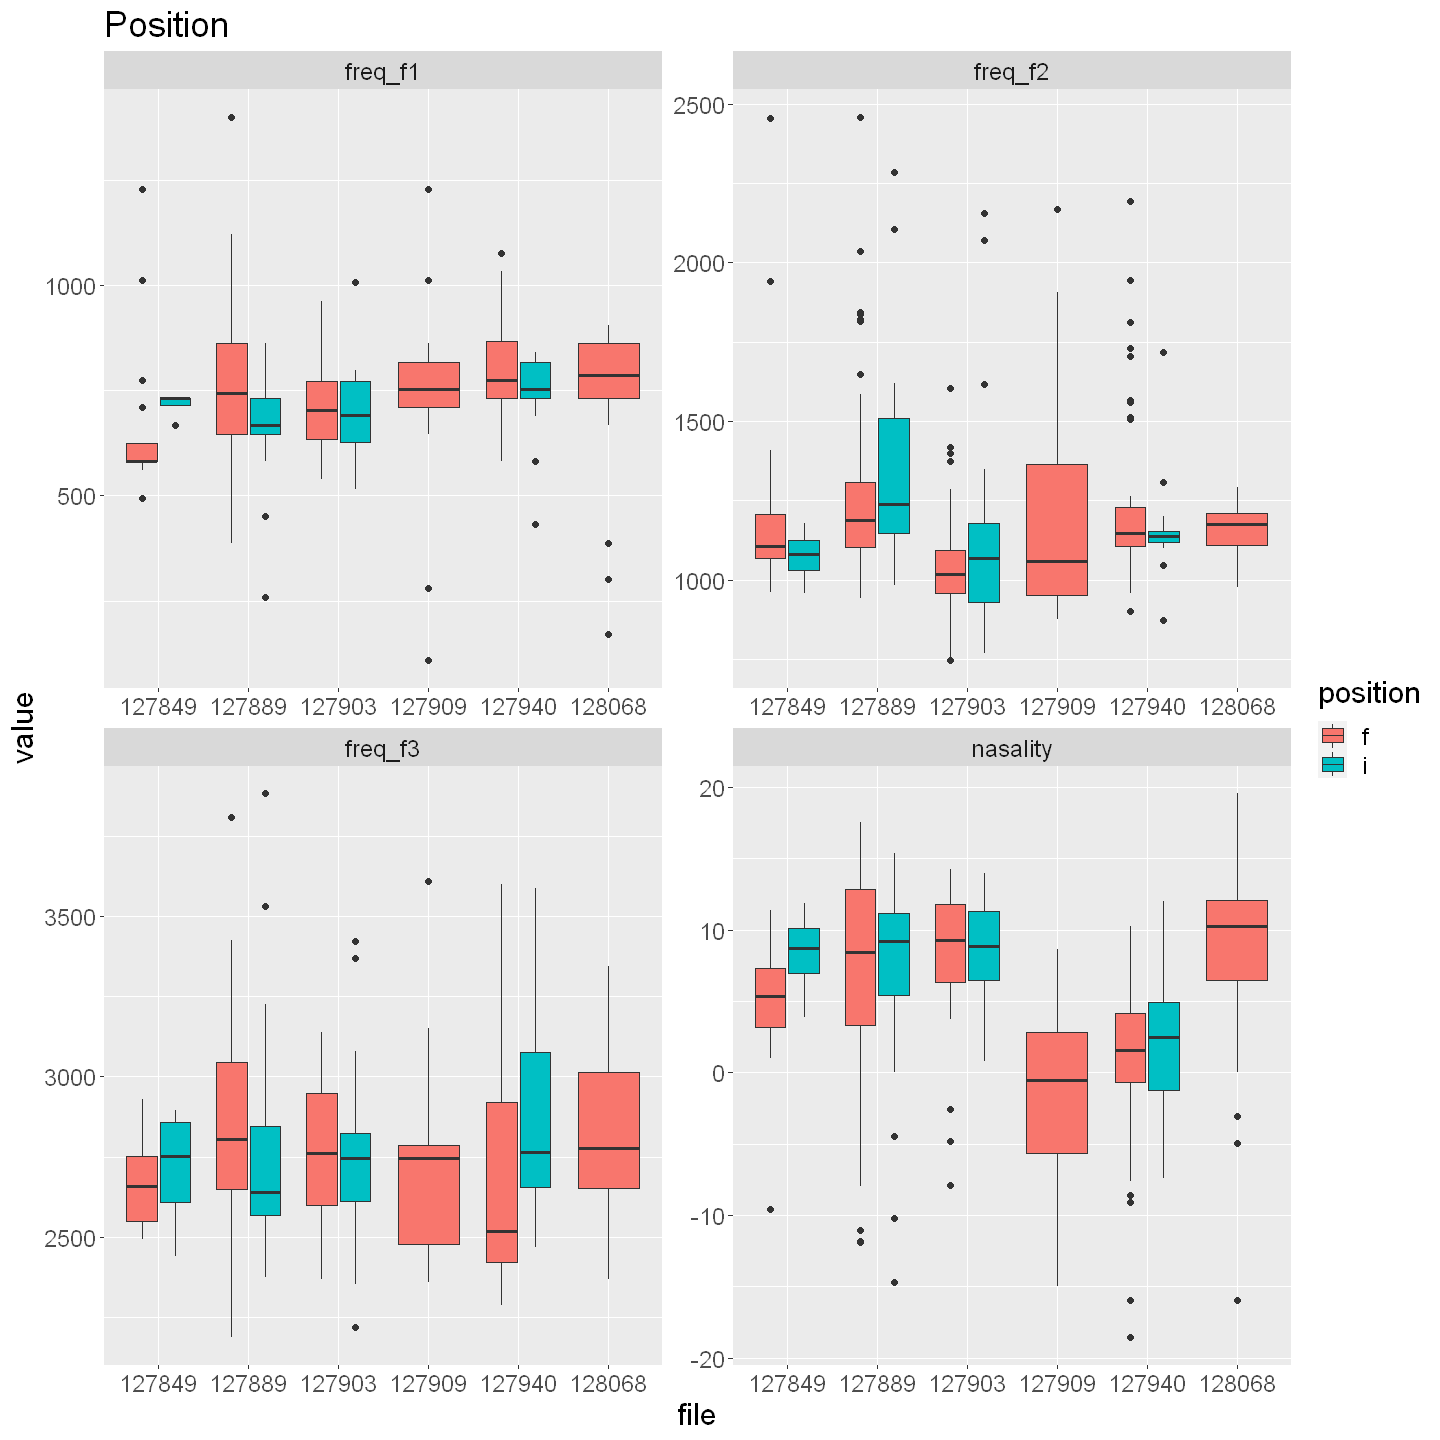

In [26]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(pdata, aes(x=file, y=value, fill=position))+ geom_boxplot() + 
    facet_wrap(.~var, scales="free") + 
    theme(text=element_text(size=18)) + 
    ggtitle("Position")

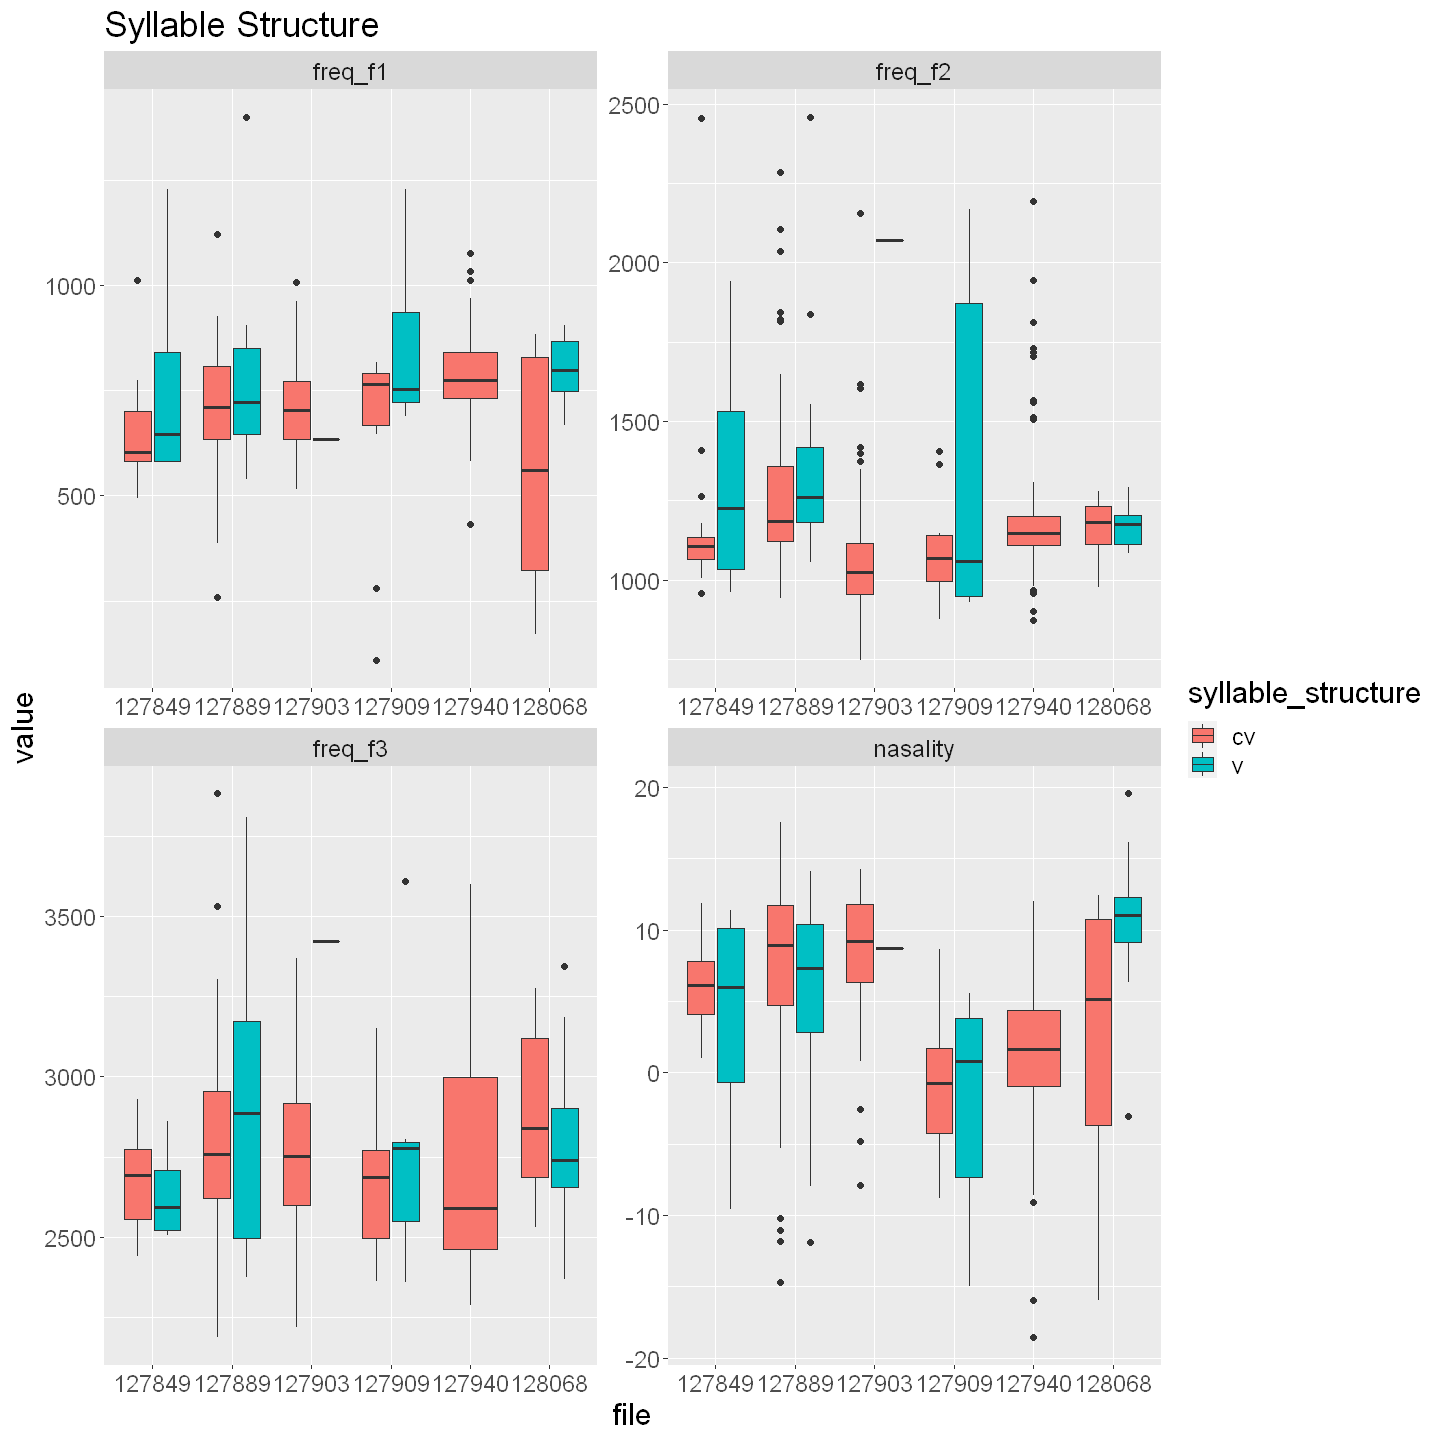

In [27]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(pdata, aes(x=file, y=value, fill=syllable_structure))+ geom_boxplot() + 
    facet_wrap(.~var, scales="free") + 
    theme(text=element_text(size=18)) + 
    ggtitle("Syllable Structure")

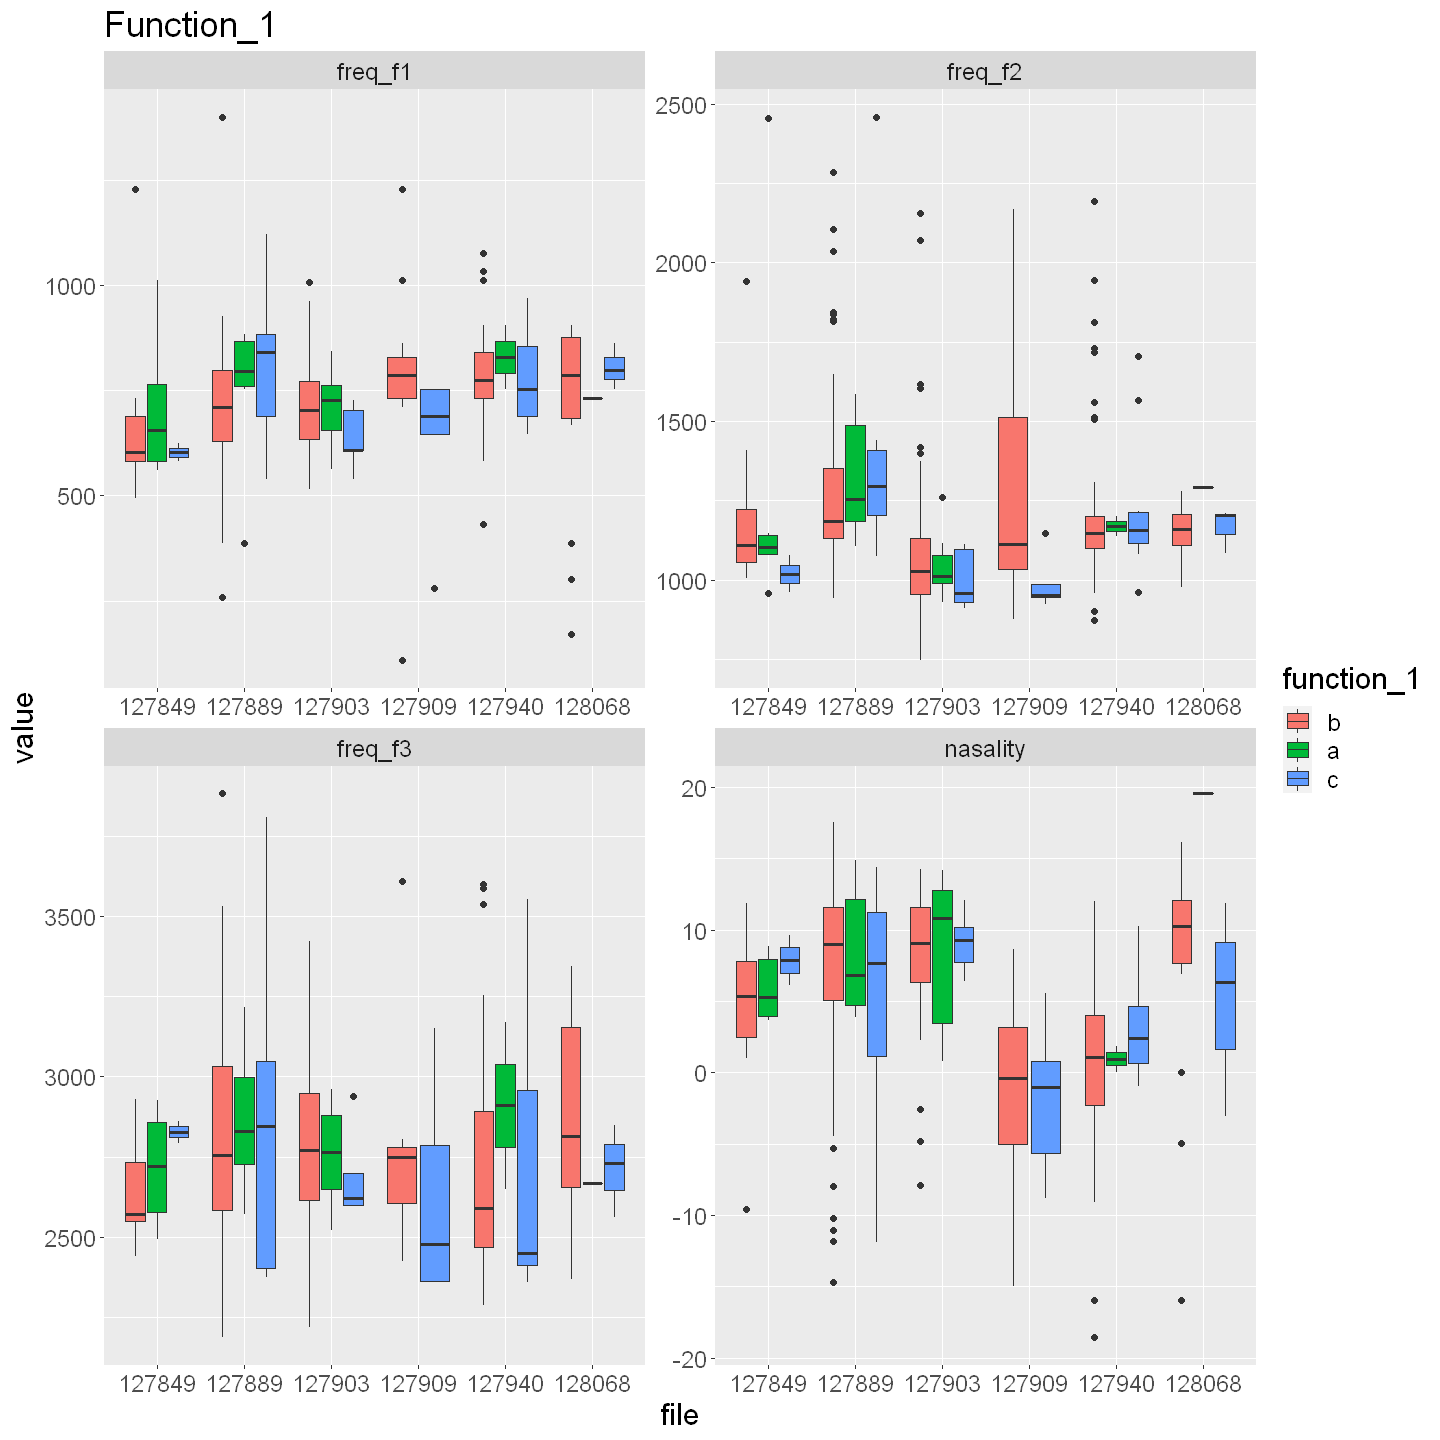

In [28]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(pdata, aes(x=file, y=value, fill=function_1))+ geom_boxplot() + 
    facet_wrap(.~var, scales="free") + 
    theme(text=element_text(size=18)) + 
    ggtitle("Function_1")
